In [2]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
train_dir = '/kaggle/input/fer2013/train'
classes = os.listdir(train_dir)
print(classes)

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


In [4]:
dataset = ImageFolder(train_dir, transform=ToTensor())

In [5]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 48, 48]) 0


tensor([[[0.1961, 0.1255, 0.0588,  ..., 0.5216, 0.5922, 0.3373],
         [0.2235, 0.1333, 0.0863,  ..., 0.5412, 0.5922, 0.3490],
         [0.2392, 0.1176, 0.0941,  ..., 0.5569, 0.5843, 0.3490],
         ...,
         [0.4039, 0.3922, 0.3922,  ..., 0.5843, 0.4078, 0.3333],
         [0.4196, 0.4353, 0.4431,  ..., 0.5922, 0.4706, 0.3373],
         [0.4078, 0.4078, 0.4392,  ..., 0.5608, 0.5333, 0.3255]],

        [[0.1961, 0.1255, 0.0588,  ..., 0.5216, 0.5922, 0.3373],
         [0.2235, 0.1333, 0.0863,  ..., 0.5412, 0.5922, 0.3490],
         [0.2392, 0.1176, 0.0941,  ..., 0.5569, 0.5843, 0.3490],
         ...,
         [0.4039, 0.3922, 0.3922,  ..., 0.5843, 0.4078, 0.3333],
         [0.4196, 0.4353, 0.4431,  ..., 0.5922, 0.4706, 0.3373],
         [0.4078, 0.4078, 0.4392,  ..., 0.5608, 0.5333, 0.3255]],

        [[0.1961, 0.1255, 0.0588,  ..., 0.5216, 0.5922, 0.3373],
         [0.2235, 0.1333, 0.0863,  ..., 0.5412, 0.5922, 0.3490],
         [0.2392, 0.1176, 0.0941,  ..., 0.5569, 0.5843, 0.

In [6]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  angry (0)


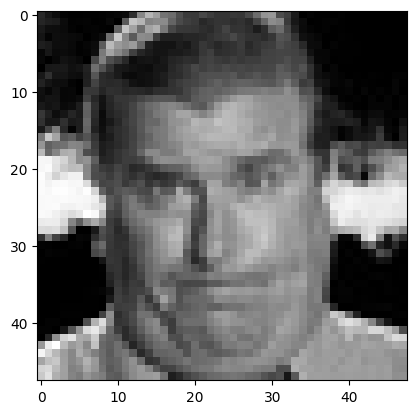

In [7]:
show_example(*dataset[100])

In [8]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(48, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [9]:
batch_size=500

In [10]:
train_ds = ImageFolder('/kaggle/input/fer2013/train', train_tfms)
valid_ds = ImageFolder('/kaggle/input/fer2013/train', valid_tfms)

In [11]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

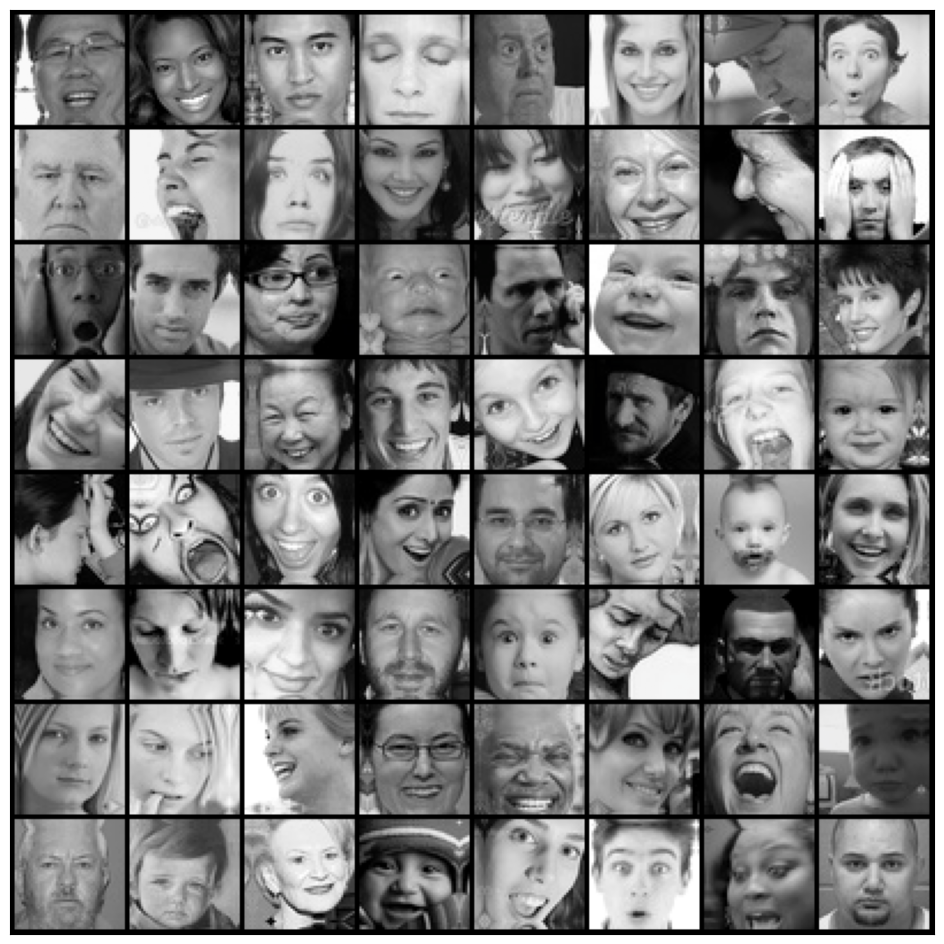

In [13]:
show_batch(train_dl)

In [14]:
def get_default_device():

    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):

    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):

        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):

        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class EmotionDetectionModel(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 96)
        self.conv2 = conv_block(96, 192, pool=True)
        self.res1 = nn.Sequential(conv_block(192, 192), conv_block(192, 192))
        
        self.conv3 = conv_block(192, 384, pool=True)
        self.conv4 = conv_block(384, 768, pool=True)
        self.res2 = nn.Sequential(conv_block(768, 768), conv_block(768, 768))
        
        self.conv5 = conv_block(768, 1024, pool=True)
        self.conv6 = conv_block(1024, 2048, pool=True)
        self.res3 = nn.Sequential(conv_block(2048, 2048), conv_block(2048, 2048))
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling to reduce spatial dimensions to 1x1
            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(2048, num_classes)
        )
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [19]:
model = to_device(EmotionDetectionModel(3, 7), device)
model

EmotionDetectionModel(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): R

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.9467147588729858, 'val_acc': 0.14653828740119934}]

In [22]:
epochs = 70
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

In [23]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00000, train_loss: 1.8548, test_loss: 1.6550, test_acc: 0.3476
Epoch [1], last_lr: 0.00001, train_loss: 1.7106, test_loss: 1.5394, test_acc: 0.4044
Epoch [2], last_lr: 0.00001, train_loss: 1.6162, test_loss: 1.4586, test_acc: 0.4449
Epoch [3], last_lr: 0.00001, train_loss: 1.5348, test_loss: 1.4029, test_acc: 0.4666
Epoch [4], last_lr: 0.00002, train_loss: 1.4799, test_loss: 1.3243, test_acc: 0.4996
Epoch [5], last_lr: 0.00002, train_loss: 1.4224, test_loss: 1.3114, test_acc: 0.5089
Epoch [6], last_lr: 0.00003, train_loss: 1.3847, test_loss: 1.2358, test_acc: 0.5336
Epoch [7], last_lr: 0.00003, train_loss: 1.3327, test_loss: 1.2524, test_acc: 0.5353
Epoch [8], last_lr: 0.00004, train_loss: 1.2809, test_loss: 1.1418, test_acc: 0.5719
Epoch [9], last_lr: 0.00005, train_loss: 1.2396, test_loss: 1.1612, test_acc: 0.5662
Epoch [10], last_lr: 0.00006, train_loss: 1.1984, test_loss: 1.1375, test_acc: 0.5758
Epoch [11], last_lr: 0.00006, train_loss: 1.1488, test_loss: 1.2

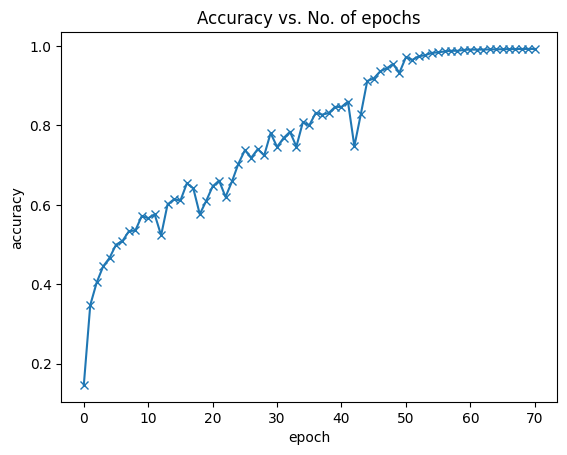

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

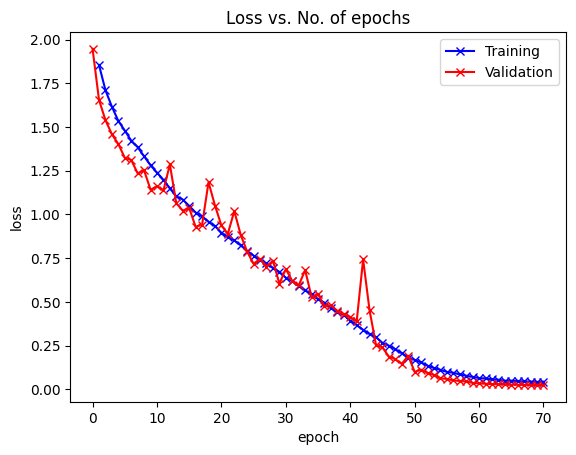

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

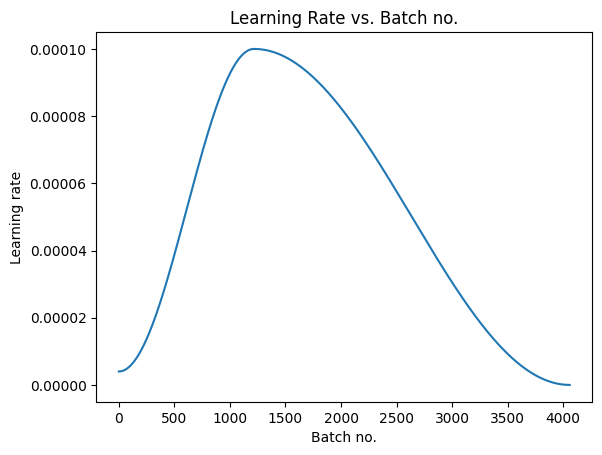

In [26]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

plot_lrs(history)

Label: angry , Predicted: angry


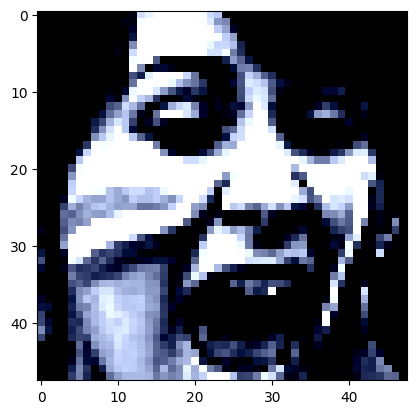

In [27]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

img, label = valid_ds[139]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: angry , Predicted: angry


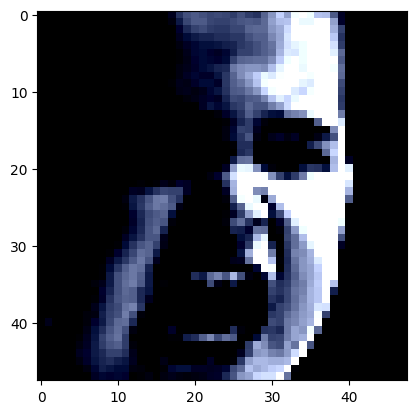

In [28]:
img, label = valid_ds[2200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: angry , Predicted: angry


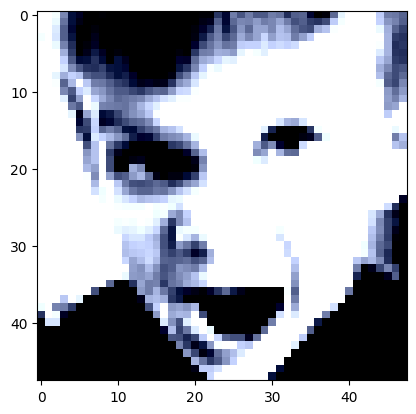

In [29]:
img, label = valid_ds[1390]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: angry , Predicted: angry


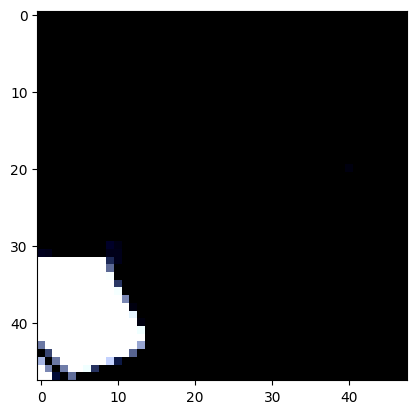

In [30]:
img, label = valid_ds[1200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: surprise , Predicted: surprise


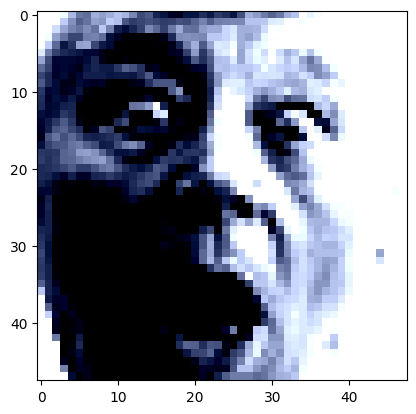

In [31]:
img, label = valid_ds[28708]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))